In [1]:
# The data setup in BiLSTM - CRF is very similar to ELMO, except the elmo uses a softmax as final classifier wheras the BiLSTM - CRF uses the CRF as the final classifier.
import pandas as pd
import matplotlib.pyplot as plt
BIO_tagged_data = pd.read_csv('BIO_tagged_data.csv', header = 0)
BIO_tagged_data = BIO_tagged_data.drop(['POS'], axis =1)
print(BIO_tagged_data.head(n=10))

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("invoice_id").apply(agg_func)
        self.invoices = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["invoice_{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

  invoice_id      token         tag
0  invoice_1    gourmet  B-MERCHANT
1  invoice_1     burger  I-MERCHANT
2  invoice_1    kitchen  I-MERCHANT
3  invoice_1          ,           O
4  invoice_1         45           O
5  invoice_1  greenwich           O
6  invoice_1     church           O
7  invoice_1          ,           O
8  invoice_1         st           O
9  invoice_1          ,           O


In [2]:
tags = list(set(BIO_tagged_data["tag"].values))
n_tags = len(tags)
n_tags

11

In [3]:
tokens = set(list(BIO_tagged_data['token'].values))
tokens.add('PADtoken')
n_tokens = len(tokens)
n_tokens

28569

In [4]:
getter = SentenceGetter(BIO_tagged_data)
sent = getter.get_next()
print(sent)

[('gourmet', 'B-MERCHANT'), ('burger', 'I-MERCHANT'), ('kitchen', 'I-MERCHANT'), (',', 'O'), ('45', 'O'), ('greenwich', 'O'), ('church', 'O'), (',', 'O'), ('st', 'O'), (',', 'O'), ('london', 'O'), (',', 'O'), ('m*07469', 'O'), (',', 'O'), ('tid', 'O'), (',', 'O'), ('tid*1', 'O'), ('*', 'O'), ('9345', 'O'), (',', 'O'), ('9345', 'O'), (',', 'O'), ('aid', 'O'), ('a0000000031010', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('e', 'O'), ('30', 'O'), ('3', 'O'), (',', 'O'), ('6162', 'O'), (',', 'O'), ('icc', 'O'), (',', 'O'), ('pan.seq', 'O'), ('01', 'O'), (',', 'O'), ('sale', 'O'), (',', 'O'), ('cardholder', 'O'), ('copy', 'O'), (',', 'O'), ('please', 'O'), ('keep', 'O'), ('this', 'O'), ('receipt', 'O'), (',', 'O'), ('for', 'O'), ('your', 'O'), ('records', 'O'), (',', 'O'), ('amount', 'O'), (',', 'O'), ('e17.75', 'O'), (',', 'O'), ('verified', 'O'), ('by', 'O'), ('signature', 'O'), (',', 'O'), ('thank', 'O'), ('you', 'O'), (',', 'O'), ('14:28', 'B-TIME'), ('22/11

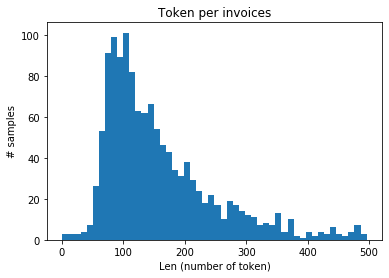

1281
longest invoices has 496 tokens


In [5]:
invoices = getter.invoices
plt.hist([len(i) for i in invoices], bins=50)
plt.title('Token per invoices')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()
print(len(invoices))
longest_inv = max(len(invoice) for invoice in invoices)
print('longest invoices has {} tokens'.format(longest_inv))

In [8]:
import statistics
statistics.mean(len(invoice) for invoice in invoices)

158.45901639344262

In [70]:
max_len = 496
word2idx = {w: i + 2 for i, w in enumerate(tokens)}
word2idx["PADtoken"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PADtoken"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
tag2idx["PADtoken"]

0

In [96]:
tag2idx

{'I-MERCHANT': 1,
 'B-DATE': 2,
 'O': 3,
 'I-TIME': 4,
 'B-GST': 5,
 'I-GST': 6,
 'I-AMOUNT': 7,
 'B-MERCHANT': 8,
 'B-AMOUNT': 9,
 'B-TIME': 10,
 'I-DATE': 11,
 'PADtoken': 0}

In [97]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in invoices]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PADtoken"])
Y = [[tag2idx[w[1]] for w in s] for s in invoices]
Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag2idx["PADtoken"])

In [98]:
from keras.utils import to_categorical
Y = [to_categorical(i, num_classes=n_tags+1) for i in Y]  # n_tags+1(PAD)

In [99]:
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.1, random_state=2020)
print(X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape)

(1152, 496) (129, 496) (1152, 496, 12) (129, 496, 12)


In [100]:
print('Raw Sample: ', ' '.join([w[0] for w in invoices[0]]))
print('Raw Label: ', ' '.join([w[1] for w in invoices[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', Y[0])

Raw Sample:  gourmet burger kitchen , 45 greenwich church , st , london , m*07469 , tid , tid*1 * 9345 , 9345 , aid a0000000031010 , visa , visa , e 30 3 , 6162 , icc , pan.seq 01 , sale , cardholder copy , please keep this receipt , for your records , amount , e17.75 , verified by signature , thank you , 14:28 22/11/14
Raw Label:  B-MERCHANT I-MERCHANT I-MERCHANT O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O B-TIME B-DATE
After processing, sample: [28514  9281 12782  8641 21705 23674 15566  8641 18266  8641  3120  8641
 19842  8641  5319  8641 12384  4106 17269  8641 17269  8641 21920 12950
  8641 25782  8641 25782  8641 25658 27851  5708  8641  3515  8641  2345
  8641 22666 25025  8641  7654  8641 17641 18600  8641 19553  3687  7626
 11169  8641 28322 24907 27633  8641  5602  8641  7805  8641 10503  1954
  3385  8641 10147 15639  8641 14452 10223     0     0     0     0     0
     0     0     0     0     0 

C:\Users\spenc\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\spenc\Anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 496)               0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 496, 20)           571400    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 496, 1024)         2183168   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 496, 512)          524800    
_________________________________________________________________
crf_5 (CRF)                  (None, 496, 12)           6324      
Total params: 3,285,692
Trainable params: 3,285,692
Non-trainable params: 0
_________________________________________________________________


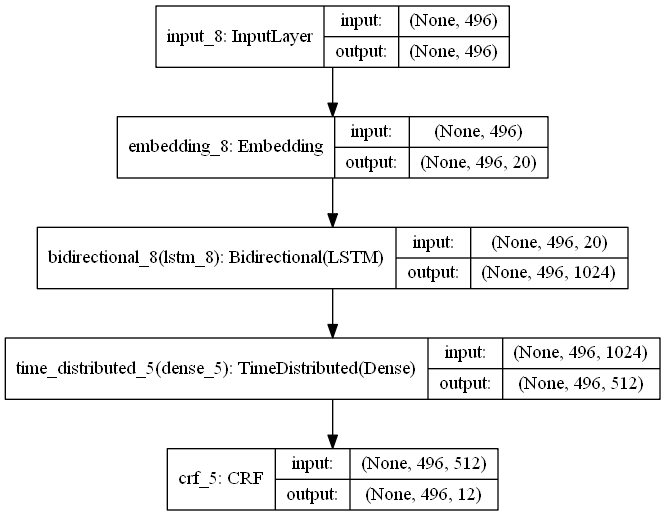

In [109]:
#ltsm - CRF
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_accuracy
from keras.utils import plot_model
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.python.keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
batch_size = 8
input_text = Input(shape=(max_len,))
sess = tf.Session(config = config)
K.set_session(sess)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

model = Embedding(input_dim=n_tokens+1, output_dim=30, # n_words + 1 (PADDING)
                  input_length=max_len)(input_text)  # default: 20-dim embedding, should i put,mask_zero = True ?
model = Bidirectional(LSTM(units=512, return_sequences=True,recurrent_dropout=0.1, dropout = 0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(512, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PADDING)
out = crf(model)  # output
model = Model(input_text, out)
model.compile(optimizer="adam", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
from IPython.display import Image 
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png')

In [103]:
print(X_tr.shape, len(y_tr)) 
temp = np.array(X_tr[:128*batch_size])
print(temp.reshape(temp.shape[0],temp.shape[1], 1).shape)
del temp

(1152, 496) 1152
(1152, 496, 1)


In [14]:
X_tr, X_val = np.array(X_tr[16*batch_size:128*batch_size]), np.array(X_tr[-32*batch_size:])
y_tr, y_val = y_tr[16*batch_size:128*batch_size], y_tr[-32*batch_size:]
# X_tr = X_tr.reshape(X_tr.shape[0], X_tr.shape[1], 1)
# X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [104]:
print(np.array(y_tr).shape)
print(X_tr.shape)

(1152, 496, 12)
(1152, 496)


In [105]:
log_dir = r"./logs/ltsm_crf"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [107]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = r'./Models/checkpoint/ltsm.crf.weights.best.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_crf_viterbi_accuracy',mode='max',save_best_only=True)
callbacks_list = [model_checkpoint_callback,tensorboard_callback]

In [108]:
history = model.fit(X_tr, np.array(y_tr), validation_split=0.11,batch_size=batch_size, epochs=100, verbose=1,callbacks=callbacks_list)

Train on 1025 samples, validate on 127 samples
Epoch 1/100
1024/1025 [============================>.] - ETA: 0s - loss: 0.4708 - crf_viterbi_accuracy: 0.8705

InvalidArgumentError: 2 root error(s) found.
  (0) Invalid argument: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,496]
	 [[{{node input_2}}]]
	 [[time_distributed_1/Reshape_1/_659]]
  (1) Invalid argument: You must feed a value for placeholder tensor 'input_2' with dtype float and shape [?,496]
	 [[{{node input_2}}]]
0 successful operations.
0 derived errors ignored.

In [19]:
model.save(r'./Models/ltsmCRFModel')
model_json = model.to_json()
with open("./Models/ltsmCRFModel.json", "w") as json_file:
    json_file.write(model_json)

In [20]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_te, verbose=1, batch_size=batch_size)

129/129 [==============================] - 15s 120ms/step


In [21]:
test = np.array(y_te)
test.shape

(129, 496, 12)

In [22]:
test_pred.shape

(129, 496, 12)

In [23]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(test)
print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

      AMOUNT       0.88      0.87      0.88       391
        DATE       0.45      0.30      0.36       183
         GST       0.47      0.40      0.43        35
    MERCHANT       0.38      0.34      0.36       194
        TIME       0.72      0.23      0.35       123

   micro avg       0.67      0.54      0.60       926
   macro avg       0.58      0.43      0.47       926
weighted avg       0.65      0.54      0.58       926



In [26]:
print(history.history.keys())

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])


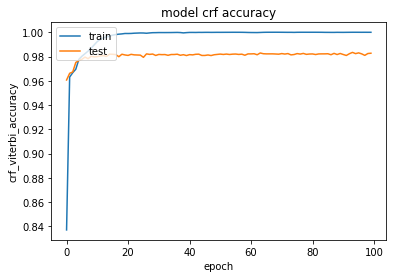

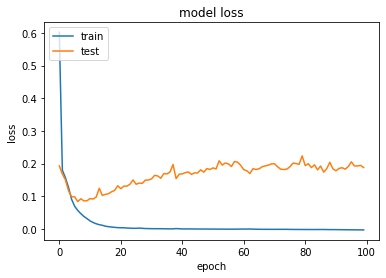

In [27]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model crf accuracy')
plt.ylabel('crf_viterbi_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.3, random_state=2020)
print(X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape)

(896, 496) (385, 496) (896, 496, 12) (385, 496, 12)


In [30]:
log_dir = r"./logs/ltsm_crf_30split_new"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = r'./Models/checkpoint/ltsm.crf.30split.weights.best.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_crf_viterbi_accuracy',mode='max',save_best_only=True)
callbacks_list = [model_checkpoint_callback,tensorboard_callback]

In [31]:
history = model.fit(X_tr, np.array(y_tr), validation_split=0.3,batch_size=batch_size, epochs=100, verbose=1,callbacks=callbacks_list)

Train on 627 samples, validate on 269 samples
Epoch 1/100
 16/627 [..............................] - ETA: 2:24 - loss: -0.0128 - crf_viterbi_accuracy: 1.0000

C:\Users\spenc\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (6429.357650). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 32/627 [>.............................] - ETA: 33:14:48 - loss: -0.0128 - crf_viterbi_accuracy: 1.0000

C:\Users\spenc\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (3214.694824). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


627/627 [==============================] - 6620s 11s/step - loss: -0.0128 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0523 - val_crf_viterbi_accuracy: 0.9941
Epoch 2/100
627/627 [==============================] - 185s 295ms/step - loss: -0.0129 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0521 - val_crf_viterbi_accuracy: 0.9941
Epoch 3/100
627/627 [==============================] - 186s 297ms/step - loss: -0.0130 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0524 - val_crf_viterbi_accuracy: 0.9941
Epoch 4/100
627/627 [==============================] - 186s 296ms/step - loss: -0.0131 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0524 - val_crf_viterbi_accuracy: 0.9941
Epoch 5/100
627/627 [==============================] - 186s 297ms/step - loss: -0.0131 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0524 - val_crf_viterbi_accuracy: 0.9941
Epoch 6/100
627/627 [==============================] - 186s 297ms/step - loss: -0.0132 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0523 - val_crf_viterb

627/627 [==============================] - 179s 285ms/step - loss: -0.0196 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0367 - val_crf_viterbi_accuracy: 0.9935
Epoch 96/100
627/627 [==============================] - 179s 285ms/step - loss: -0.0196 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0364 - val_crf_viterbi_accuracy: 0.9935
Epoch 97/100
627/627 [==============================] - 179s 285ms/step - loss: -0.0197 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0352 - val_crf_viterbi_accuracy: 0.9935
Epoch 98/100
627/627 [==============================] - 179s 285ms/step - loss: -0.0197 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0361 - val_crf_viterbi_accuracy: 0.9935
Epoch 99/100
627/627 [==============================] - 179s 285ms/step - loss: -0.0198 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0363 - val_crf_viterbi_accuracy: 0.9935
Epoch 100/100
627/627 [==============================] - 180s 287ms/step - loss: -0.0199 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.0367 - val_crf

In [32]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_te, verbose=1, batch_size=batch_size)
test = np.array(y_te)
test.shape
test_pred.shape
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(test)
print(classification_report(test_labels, pred_labels))

385/385 [==============================] - 41s 107ms/step
              precision    recall  f1-score   support

      AMOUNT       0.96      0.96      0.96      1330
        DATE       0.85      0.74      0.79       562
         GST       0.76      0.79      0.78       117
    MERCHANT       0.77      0.75      0.76       613
        TIME       0.96      0.77      0.85       360

   micro avg       0.89      0.85      0.87      2982
   macro avg       0.86      0.80      0.83      2982
weighted avg       0.89      0.85      0.87      2982



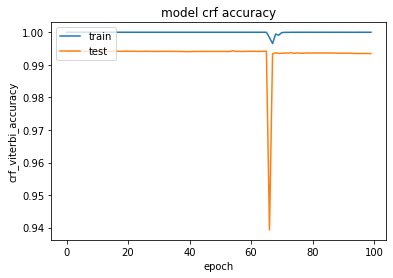

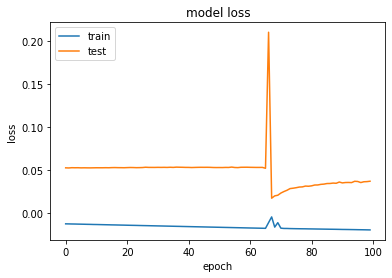

In [33]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model crf accuracy')
plt.ylabel('crf_viterbi_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


  invoice_id    token         tag
0  invoice_1  gourmet  B-MERCHANT
1  invoice_1   burger  I-MERCHANT
2  invoice_1  kitchen  I-MERCHANT
3  invoice_1        ,           O
4  invoice_1       45           O
[('gourmet', 'B-MERCHANT'), ('burger', 'I-MERCHANT'), ('kitchen', 'I-MERCHANT'), (',', 'O'), ('45', 'O'), ('greenwich', 'O'), ('church', 'O'), (',', 'O'), ('st', 'O'), (',', 'O'), ('london', 'O'), (',', 'O'), ('m*07469', 'O'), (',', 'O'), ('tid', 'O'), (',', 'O'), ('tid*1', 'O'), ('*', 'O'), ('9345', 'O'), (',', 'O'), ('9345', 'O'), (',', 'O'), ('aid', 'O'), ('a0000000031010', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('visa', 'O'), (',', 'O'), ('e', 'O'), ('30', 'O'), ('3', 'O'), (',', 'O'), ('6162', 'O'), (',', 'O'), ('icc', 'O'), (',', 'O'), ('pan.seq', 'O'), ('01', 'O'), (',', 'O'), ('sale', 'O'), (',', 'O'), ('cardholder', 'O'), ('copy', 'O'), (',', 'O'), ('please', 'O'), ('keep', 'O'), ('this', 'O'), ('receipt', 'O'), (',', 'O'), ('for', 'O'), ('your', 'O'), ('records', 'O'), 

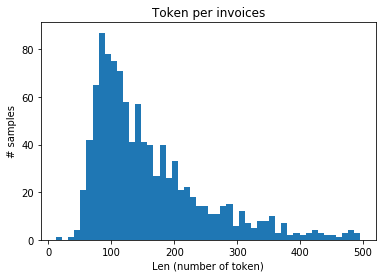

1046
longest invoices has 496 tokens


0

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
BIO_tagged_data_conf = pd.read_csv('BIO_tagged_data_conf.csv', header = 0)
BIO_tagged_data_conf = BIO_tagged_data_conf.drop(['POS'], axis =1)
print(BIO_tagged_data_conf.head(n=5))

class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("invoice_id").apply(agg_func)
        self.invoices = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["invoice_{}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
tags = list(set(BIO_tagged_data_conf["tag"].values))
n_tags = len(tags)
n_tags
tokens = set(list(BIO_tagged_data_conf['token'].values))
tokens.add('PADtoken')
n_tokens = len(tokens)
n_tokens
getter = SentenceGetter(BIO_tagged_data_conf)
sent = getter.get_next()
print(sent)
invoices = getter.invoices
plt.hist([len(i) for i in invoices], bins=50)
plt.title('Token per invoices')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()
print(len(invoices))
longest_inv = max(len(invoice) for invoice in invoices)
print('longest invoices has {} tokens'.format(longest_inv))
max_len = 496
word2idx = {w: i + 2 for i, w in enumerate(tokens)}
word2idx["PADtoken"] = 0 # Padding
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PADtoken"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}
tag2idx["PADtoken"]

In [51]:
tag2idx

{'I-MERCHANT': 1,
 'B-DATE': 2,
 'O': 3,
 'I-TIME': 4,
 'B-GST': 5,
 'I-GST': 6,
 'I-AMOUNT': 7,
 'B-MERCHANT': 8,
 'B-AMOUNT': 9,
 'B-TIME': 10,
 'I-DATE': 11,
 'PADtoken': 0}

In [52]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in invoices]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word2idx["PADtoken"])
Y = [[tag2idx[w[1]] for w in s] for s in invoices]
Y = pad_sequences(maxlen=max_len, sequences=Y, padding="post", value=tag2idx["PADtoken"])
from keras.utils import to_categorical
Y = [to_categorical(i, num_classes=n_tags+1) for i in Y]  # n_tags+1(PAD)
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=0.1, random_state=2020)
print(X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape)

(941, 496) (105, 496) (941, 496, 12) (105, 496, 12)


In [55]:
log_dir = r"./logs/ltsm_crf_conf"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = r'./Models/checkpoint/ltsm.crf.conf.weights.best.h5'
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,save_weights_only=True,monitor='val_crf_viterbi_accuracy',mode='max',save_best_only=True)
callbacks_list = [model_checkpoint_callback,tensorboard_callback]

In [56]:
history = model.fit(X_tr, np.array(y_tr), validation_split=0.1,batch_size=batch_size, epochs=100, verbose=1,callbacks=callbacks_list)

Train on 846 samples, validate on 95 samples
Epoch 1/100
846/846 [==============================] - 201s 238ms/step - loss: 0.0971 - crf_viterbi_accuracy: 0.9682 - val_loss: 0.0362 - val_crf_viterbi_accuracy: 0.9818
Epoch 2/100
846/846 [==============================] - 202s 239ms/step - loss: 0.0211 - crf_viterbi_accuracy: 0.9849 - val_loss: 0.0237 - val_crf_viterbi_accuracy: 0.9854
Epoch 3/100
846/846 [==============================] - 202s 238ms/step - loss: 0.0024 - crf_viterbi_accuracy: 0.9909 - val_loss: 0.0215 - val_crf_viterbi_accuracy: 0.9858
Epoch 4/100
846/846 [==============================] - 202s 239ms/step - loss: -0.0070 - crf_viterbi_accuracy: 0.9945 - val_loss: 0.0230 - val_crf_viterbi_accuracy: 0.9860
Epoch 5/100
846/846 [==============================] - 206s 244ms/step - loss: -0.0118 - crf_viterbi_accuracy: 0.9967 - val_loss: 0.0275 - val_crf_viterbi_accuracy: 0.9865
Epoch 6/100
846/846 [==============================] - 201s 238ms/step - loss: -0.0143 - crf_viter

846/846 [==============================] - 197s 233ms/step - loss: -0.0295 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1095 - val_crf_viterbi_accuracy: 0.9847
Epoch 96/100
846/846 [==============================] - 197s 233ms/step - loss: -0.0296 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1137 - val_crf_viterbi_accuracy: 0.9848
Epoch 97/100
846/846 [==============================] - 197s 233ms/step - loss: -0.0297 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1131 - val_crf_viterbi_accuracy: 0.9847
Epoch 98/100
846/846 [==============================] - 197s 233ms/step - loss: -0.0298 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1160 - val_crf_viterbi_accuracy: 0.9846
Epoch 99/100
846/846 [==============================] - 197s 233ms/step - loss: -0.0300 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1196 - val_crf_viterbi_accuracy: 0.9847
Epoch 100/100
846/846 [==============================] - 197s 233ms/step - loss: -0.0301 - crf_viterbi_accuracy: 1.0000 - val_loss: 0.1208 - val_crf

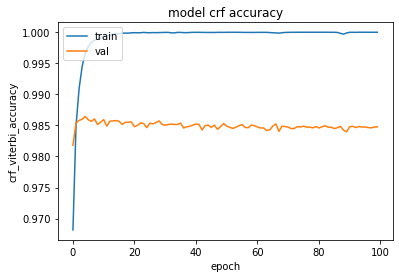

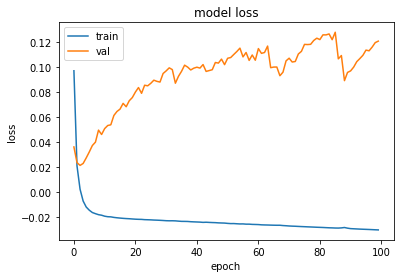

In [58]:
plt.plot(history.history['crf_viterbi_accuracy'])
plt.plot(history.history['val_crf_viterbi_accuracy'])
plt.title('model crf accuracy')
plt.ylabel('crf_viterbi_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [59]:
test = np.array(y_te)
test.shape
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
test_pred = model.predict(X_te, verbose=1, batch_size=batch_size)
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADtoken", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(test_pred)
test_labels = test2label(test)
print(classification_report(test_labels, pred_labels))

105/105 [==============================] - 11s 103ms/step
              precision    recall  f1-score   support

      AMOUNT       0.89      0.81      0.85       377
        DATE       0.60      0.32      0.42       186
         GST       0.76      0.71      0.73        31
    MERCHANT       0.49      0.39      0.43       150
        TIME       0.67      0.31      0.43       112

   micro avg       0.75      0.56      0.64       856
   macro avg       0.68      0.51      0.57       856
weighted avg       0.72      0.56      0.62       856



In [64]:
print(BIO_tagged_data.head(n=10))

  invoice_id      token         tag
0  invoice_1    gourmet  B-MERCHANT
1  invoice_1     burger  I-MERCHANT
2  invoice_1    kitchen  I-MERCHANT
3  invoice_1          ,           O
4  invoice_1         45           O
5  invoice_1  greenwich           O
6  invoice_1     church           O
7  invoice_1          ,           O
8  invoice_1         st           O
9  invoice_1          ,           O


In [65]:
sess.close()

NameError: name 'sess' is not defined